Epoch 100 - Hinge Loss: 0.5038
Epoch 200 - Hinge Loss: 0.4930
Epoch 300 - Hinge Loss: 0.4834
Epoch 400 - Hinge Loss: 0.4740
Epoch 500 - Hinge Loss: 0.4647
Epoch 600 - Hinge Loss: 0.4554
Epoch 700 - Hinge Loss: 0.4465
Epoch 800 - Hinge Loss: 0.4376
Epoch 900 - Hinge Loss: 0.4289
Epoch 1000 - Hinge Loss: 0.4204
Epoch 1100 - Hinge Loss: 0.4121
Epoch 1200 - Hinge Loss: 0.4037
Epoch 1300 - Hinge Loss: 0.3957
Epoch 1400 - Hinge Loss: 0.3879
Epoch 1500 - Hinge Loss: 0.3800
Epoch 1600 - Hinge Loss: 0.3728

Classification Report (Test Set):
              precision    recall  f1-score   support

       Legit       0.97      0.82      0.89     56863
       Fraud       0.84      0.97      0.90     56863

    accuracy                           0.90    113726
   macro avg       0.91      0.90      0.90    113726
weighted avg       0.91      0.90      0.90    113726



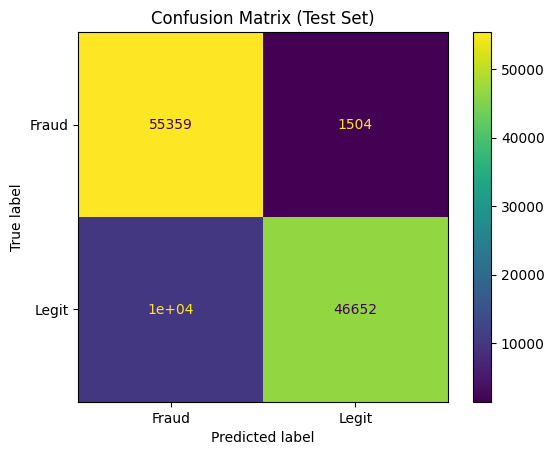

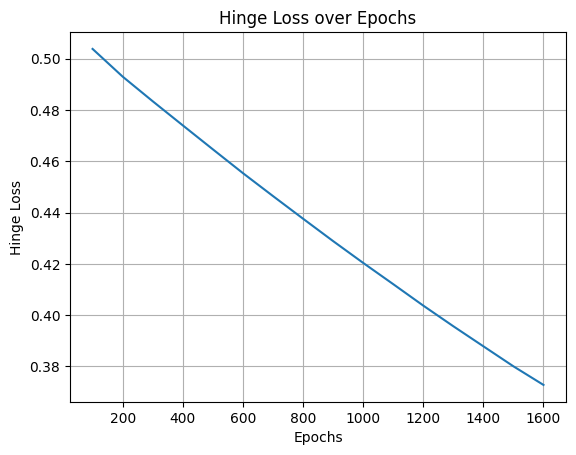


--- Report Summary ---
Rows of Data Used: 284807
Test Set Accuracy: 0.8970
Precision: 0.8443
Recall: 0.9736
Weighted F1 Score: 0.8964
AUC-ROC Score: 0.8970


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# Load and preprocess data
nRowsRead = None
df = pd.read_csv('/content/creditcard.csv', delimiter=',', nrows=nRowsRead)
df.dataframeName = 'creditcard.csv'

# Drop irrelevant columns
x = df.drop(columns=['Time', 'Amount', 'Class'])
y = df['Class'].copy()

# Convert 0 -> -1 for SVM
y = y.replace(0, -1)

# Standard scaling
scaler = StandardScaler()
x = scaler.fit_transform(x.to_numpy())
y = y.to_numpy()

# SMOTE balancing
smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

# Train-test split after SMOTE
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Hinge loss function
def hinge_loss(y, y_hat):
    return np.maximum(0, 1 - y * y_hat)

# Forward pass
def forward(x, w):
    return np.dot(x, w)

# Gradient calculation
def svm_gradient(x_i, y_i, w, epoch):
    if y_i * forward(x_i, w) < 1:
        return (x_i * y_i) - 2 * (1 / epoch) * w
    else:
        return -2 * (1 / epoch) * w

# Weight update
def optimize(w, dw, lr):
    return w + lr * dw

# SVM training function
def svm(x, y, w, epochs=1601, lr=0.001):
    losses = []
    for epoch in range(1, epochs):
        for i in range(len(x)):
            dw = svm_gradient(x[i], y[i], w, epoch)
            w = optimize(w, dw, lr)
        if epoch % 100 == 0:
            y_hat = forward(x, w)
            loss = hinge_loss(y, y_hat).mean()
            losses.append(loss)
            print(f"Epoch {epoch} - Hinge Loss: {loss:.4f}")
    return w, losses

# Train
w = np.zeros(x_train.shape[1])
w, losses = svm(x_train, y_train, w)

# Predictions
y_train_pred = forward(x_train, w)
y_test_pred = forward(x_test, w)

# Convert to class labels
y_train_class = np.where(y_train_pred > 0, 1, -1)
y_test_class = np.where(y_test_pred > 0, 1, -1)

# Evaluation metrics
train_acc = accuracy_score(y_train, y_train_class)
test_acc = accuracy_score(y_test, y_test_class)
precision = precision_score(y_test, y_test_class, pos_label=1)
recall = recall_score(y_test, y_test_class, pos_label=1)
f1 = f1_score(y_test, y_test_class, average='weighted')
auc = roc_auc_score(np.where(y_test == 1, 1, 0), np.where(y_test_class == 1, 1, 0))

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_class, target_names=["Legit", "Fraud"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_class, labels=[1, -1])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Fraud", "Legit"])
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Loss curve
plt.plot(range(100, 1700, 100), losses)
plt.title('Hinge Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Hinge Loss')
plt.grid(True)
plt.show()

# Report Summary
rows_used = len(df)

print("\n--- Report Summary ---")
print(f"Rows of Data Used: {rows_used}")
print(f"Test Set Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc:.4f}")
